In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split


mer = pd.read_json("025_segments_matched_with_raw.jsonl", orient="records", lines=True)
mer.shape
mer.head(3)

,file,segment_file,start,end,asr_transcription,kaldi_transcript,raw_transcript__matched_on_kaldi,raw_transcript__matched_on_asr,guest_name,guest_description,host,kaldi_words,kaldi_word_starts,kaldi_word_ends,speaker_breakdown,average_distance,similarity_ratio
0,audio/58xZSVbpgkk.wav,seg_audio/58xZSVbpgkk__12.0__31.0__.wav,12.0,31.0,nekoliko puta smo ponavljali da nišo od uvođen...,nekoliko tema je bilo u skupštini znači niške ...,"nekoliko tema je bilo u Skupštini! Znači, nišk...",Nekoliko puta smo ponavljali da Niš od uvođenj...,Slavoljub Vlajković,narodni poslanik SPS iz Niša,Predrag Blagojević,"[nekoliko, tema, je, bilo, u, skupštini, znači...","[12.47, 13.3, 13.45, 13.51, 13.65, 14.66, 15.0...","[12.89, 13.45, 13.51, 13.65, 13.68, 15.0, 15.5...","[[guest, 12.47, 16.79], [host, 16.79, 19.03], ...",5.142857,44
1,audio/58xZSVbpgkk.wav,seg_audio/58xZSVbpgkk__31.0__47.0__.wav,31.0,47.0,nikad više pa niti iskoristio niti će izgledat...,nikad više<anchor_end> niti je iskoristio niti...,"nikad više?’ Niti je iskoristio, niti će izgle...","nikad više?’ Niti je iskoristio, niti će izgle...",Slavoljub Vlajković,narodni poslanik SPS iz Niša,Predrag Blagojević,"[nikad, više<anchor_end>, niti, je, iskoristio...","[31.17, 31.46, 32.62, 32.83, 32.89, 33.54, 33....","[31.46, 31.74, 32.83, 32.89, 33.54, 33.75, 33....","[[host, 31.17, 31.74], [guest, 31.74, 36.67], ...",3.604167,89
2,audio/58xZSVbpgkk.wav,seg_audio/58xZSVbpgkk__47.0__62.5__.wav,47.0,62.5,dobrani i znate da e svaka stranka od polih pr...,vi znate da svaka stranka otprilike predloži d...,znate da svaka stranka otprilike predloži 250 ...,izabrani. Vi znate da svaka stranka otprilike ...,Slavoljub Vlajković,narodni poslanik SPS iz Niša,Predrag Blagojević,"[vi, znate, da, svaka, stranka, otprilike, pre...","[47.74, 47.84, 48.12, 48.19, 48.49, 48.89, 49....","[47.84, 48.12, 48.19, 48.49, 48.89, 49.22, 49....","[[host, 47.74, 62.25]]",5.729730,89


# Filtering

In preliminary inspections I drew some conclusions:

1. num_words and length do not correlate with similarity_ratio.
2. I can filter out all instances with length not in [10, 70] bracket and still keep the majority of the data.
3. To drop all instances with mismatched raw transcriptions we can do a pairwise ratio calculation and drop those that have at least one result < 75.

In [33]:
from fuzzywuzzy.fuzz import ratio

def preprocess(s: str) -> str:
    """Remove puctuation, JV, anchor tags, punctuation, and redundant whitespace."""
    from string import punctuation
    for p in punctuation:
        s = s.replace(p, "")
    return " ".join(
        s.replace("JV", "").split()
    ).casefold().replace("<anchor_start>", "").replace("<anchor_end>", "")

mer["num_words"] = mer.kaldi_words.apply(len)
mer["length"] = mer.end - mer.start


mer["similarity_kaldi_match_vs_asr_match"] = mer.apply(
    lambda row: ratio(
        preprocess(row["raw_transcript__matched_on_kaldi"]),
        preprocess(row["raw_transcript__matched_on_asr"])),
    axis=1
)
mer["similarity_kaldi_vs_asr"] = mer.apply(
    lambda row: ratio(
        preprocess(row["kaldi_transcript"]),
        preprocess(row["asr_transcription"])),
    axis=1
)
mer["similarity_kaldi_match_vs_asr"] = mer.apply(
    lambda row: ratio(
        preprocess(row["raw_transcript__matched_on_kaldi"]),
        preprocess(row["asr_transcription"])),
    axis=1
)
mer["similarity_kaldi_vs_asr_match"] = mer.apply(
    lambda row: ratio(
        preprocess(row["kaldi_transcript"]),
        preprocess(row["raw_transcript__matched_on_asr"])),
    axis=1
)

mer["is_acceptable"] = mer.apply(
    lambda row: all([
        row[i] > 75 for i in [
            "similarity_kaldi_vs_asr_match",
            "similarity_kaldi_match_vs_asr_match",
            "similarity_kaldi_match_vs_asr",
            "similarity_kaldi_vs_asr"
        ]
    ],
    ), axis=1
)


In [34]:

mer = mer[mer.is_acceptable & (mer.length <= 30)]
mer.shape

(10811, 24)

In [35]:
mer.length.sum()/3600


50.55213888888889

In [36]:
train, devtest = train_test_split(mer, train_size=0.8)
test, dev = train_test_split(devtest, test_size=0.5)
train["split"] = "train"
test["split"] = "test"
dev["split"] = "dev"


newmer = pd.concat([train, dev, test], ignore_index=True).reset_index(drop=True)

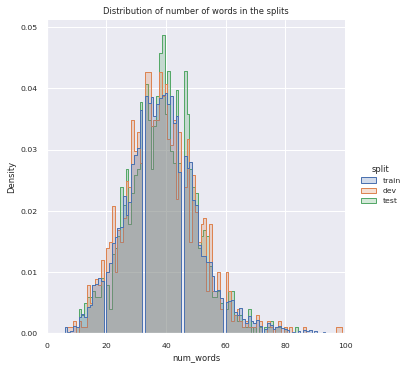

In [37]:
import seaborn as sns

sns.displot(data=newmer, 
    hue="split", 
    x="num_words",
    stat="density",
    bins=100,
    element="step", 
    common_norm=False, 
    log_scale=(False, False),
    kind="hist").set(title="Distribution of number of words in the splits", xlim = (0, 100))


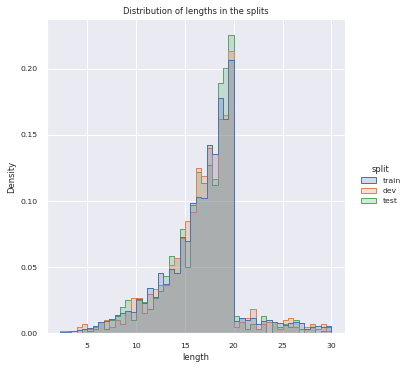

In [38]:
sns.displot(data=newmer, 
    hue="split", 
    x="length",
    stat="density",
    bins=50, 
    element="step", 
    common_norm=False, 
    log_scale=(False, False),
    kind="hist",).set(
    title="Distribution of lengths in the splits",    
    )


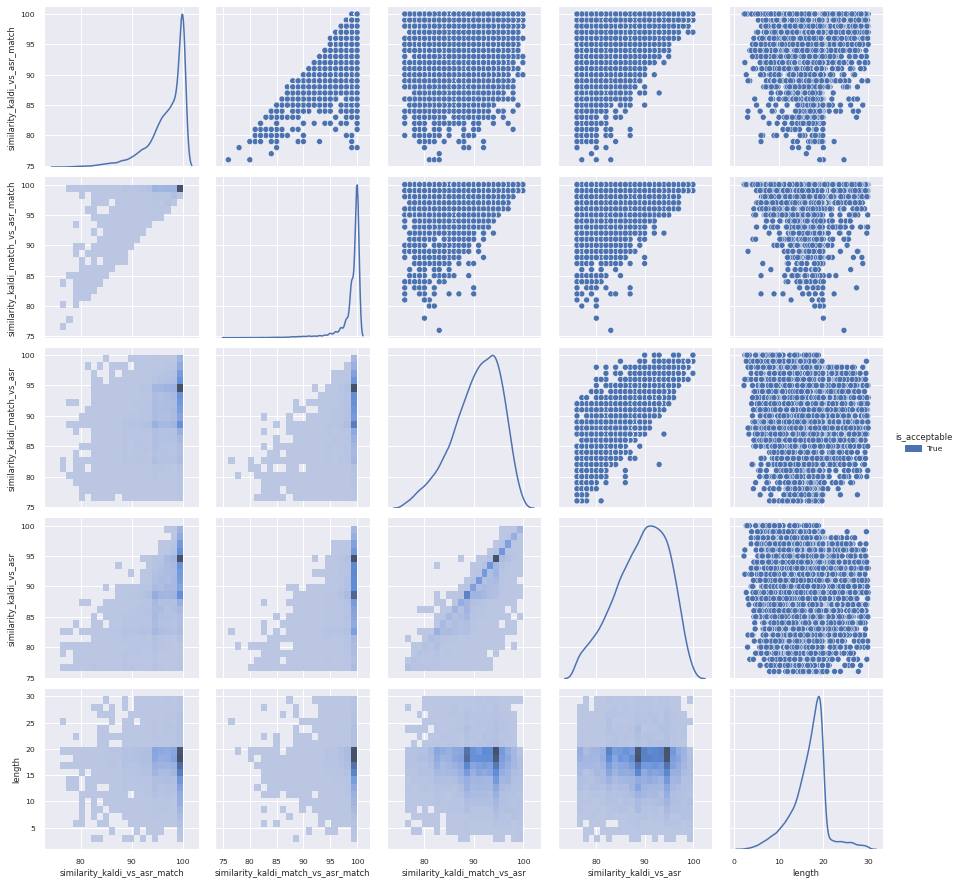

In [39]:
sns.set(font_scale=0.7)

g = sns.PairGrid(mer, hue="is_acceptable", vars=[
            "similarity_kaldi_vs_asr_match",
            "similarity_kaldi_match_vs_asr_match",
            "similarity_kaldi_match_vs_asr",
            "similarity_kaldi_vs_asr",
            "length"
        ],
        diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot )
g.map_lower(sns.histplot, bins=(20, 20))

g.add_legend()
# g.savefig("images/26_similarity_analysis.pdf")
# g.savefig("images/26_similarity_analysis.png")

In [45]:
newmer.to_json("026_JV_segments_splits.jsonl", lines=True, orient="records")

In [47]:
newmer.raw_transcript__matched_on_kaldi.str.contains("JV:").sum()/newmer.shape[0]

0.19563407640366293